In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dateparser import parse
import pandas as pd
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmcrameri.cm as cmc
import os

In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask

cluster = SLURMCluster(cores=1, memory="2GB")
cluster.scale(jobs=100)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.0.0.47:8787/status,
Dashboard: http://10.0.0.47:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.0.47:43189,Workers: 0
Dashboard: http://10.0.0.47:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
# load bathymetry
bat = xr.open_dataset("../data/gebco_2022_n21.4673_s-7.4048_w-68.6426_e-32.7393.nc").elevation
bat = bat.sel(lat=slice(-7.5,15,10), lon=slice(-66,-30,10))

oscar = xr.open_mfdataset("../data/OSCAR_L4_OC_NRT_V2.0/*.nc", parallel=True)
oscar = oscar.assign_coords(time=[parse(time.strftime()) for time in oscar.time.values])
oscar = oscar.assign_coords(lon=(((oscar.lon + 180) % 360) - 180))
oscar = oscar.rename(lon="longitude", lat="latitude")
oscar = oscar.assign_coords(longitude=oscar.longitude, latitude=oscar.latitude)
oscar = oscar[["u","v"]].sel(latitude=slice(-7.4,15), longitude=slice(-66,-30))
oscar = oscar.transpose("latitude","longitude","time")
oscar = oscar.assign(spd=np.sqrt(oscar.u**2 + oscar.v**2))
oscar = oscar.load()


/tmp/ipykernel_423978/2838795396.py:8: UserWarning: rename 'lon' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  oscar = oscar.rename(lon="longitude", lat="latitude")
/tmp/ipykernel_423978/2838795396.py:8: UserWarning: rename 'lat' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  oscar = oscar.rename(lon="longitude", lat="latitude")


In [4]:
tico = xr.open_dataset("../data/tico_filtrado.nc")

# Video

In [5]:
def integrate(field, dt=3600, nparticles=1000, update_dist=100, quantile=0.1):
    
    xinit,yinit = np.meshgrid(np.arange(-65,-30, 0.1), np.arange(-6,15, 0.1))

    xinit, yinit = xinit.ravel(), yinit.ravel()

    field_i = field.u.isel(time=0).interp(longitude=("particles",xinit), latitude=("particles",yinit)).dropna("particles")

    xinit, yinit = field_i.longitude.values, field_i.latitude.values

    ind = np.random.randint(0,xinit.size,nparticles)
    xi, yi = xinit[ind], yinit[ind]

    x = []
    y = []

    times = pd.date_range(start=field.time.min().values, end=field.time.max().values, freq=f"{dt}s").values
    i = 0
    for timei in tqdm(times):
        dxdy = field.sel(time=timei,method="nearest").interp(longitude=("particle",xi),latitude=("particle",yi))*dt
        xi = (xi+dxdy.u).values
        yi = (yi+dxdy.v).values
        x.append(xi.copy())
        y.append(yi.copy())

        nans = np.isnan(xi)
        if nans.sum()>0:
            ind = np.random.randint(0,int(xinit.size*quantile),nans.sum())
            xi[nans], yi[nans] = xinit[ind], yinit[ind]

        if i%update_dist==0:
            dist = np.array([np.nanmin(np.sqrt((xii-xi)**2+(yii-yi)**2)) for xii,yii in zip(xinit,yinit)])
            ind = np.argsort(dist)[::-1]
            xinit, yinit = xinit[ind], yinit[ind]
        i = i+1
        
        
    x = np.vstack(x)
    y = np.vstack(y)

    x = xr.DataArray(x,dims=["time","particles"],
             coords=dict(
                 time=("time",times),
                 particles=("particles",np.arange(nparticles))
             ),name="x")
    y = xr.DataArray(y,dims=["time","particles"],
             coords=dict(
                 time=("time",times),
                 particles=("particles",np.arange(nparticles))
             ),name="y")

    output = xr.merge([x,y])
    
    return output

In [6]:
nparticles=3000
dt = 3600
oscari = oscar[["u","v"]]/112e3
valid = ~np.isnan(oscari)
oscari = oscari.where(bat.interp(lon=oscari.longitude,lat=oscari.latitude)<-200)
# oscari = oscari.rolling(latitude=7,longitude=7,center=True,min_periods=1).mean()
# oscari = oscari.where(valid)

In [7]:
particles = integrate(oscari, dt=dt, nparticles=nparticles)

100%|██████████| 1465/1465 [01:01<00:00, 23.70it/s]


In [8]:
ti = particles.time.values[800]
dsi = tico.sel(time=slice(ti-np.timedelta64(5,"D"),ti))
particles_i = particles.sel(time=slice(ti-np.timedelta64(5,"D"),ti)).dropna("particles",how="all")


/autofs/nas1/home/isimoesdesousa/programs/mambaforge/envs/coringa/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


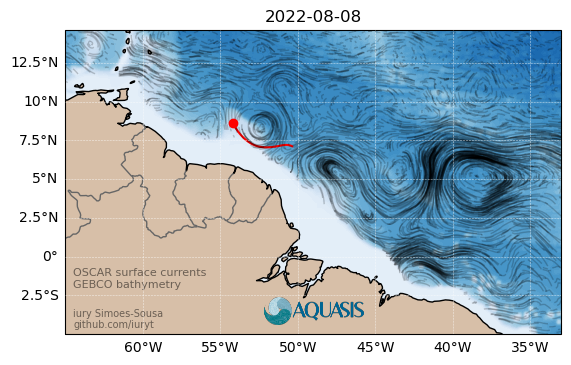

In [38]:
projection = ccrs.PlateCarree()

im = plt.imread("../img/nova-logo-aquasis-digital.png")

fig = plt.figure()
ax = fig.add_subplot(projection=projection)
bat.rolling(lon=5,lat=5).mean().plot.contourf(ax=ax,transform=projection,levels=50, vmin=-8000, vmax=800, cmap="Blues_r", extend="max", add_colorbar=False)
ax.add_feature(cfeature.LAND, facecolor="#d7bfa8",zorder=1)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, color="0.4")
ax.gridlines(draw_labels=["left","bottom"],linewidth=0.4,linestyle="--",transform=projection,zorder=1e4,color="w",alpha=0.7)
_ = ax.plot(particles_i.x,particles_i.y,color="0.0",lw=1,alpha=0.2,zorder=1e3,transform=projection)
if dsi.longitude.size>2:
    ax.plot(dsi.longitude, dsi.latitude,color="red")
    ax.scatter(dsi.longitude.values[-1], dsi.latitude.values[-1],color="red",zorder=1e3,transform=projection)
ax.set(extent=[-65,-33,-5,14.5])
ax.set_title(f"{np.datetime_as_string(particles_i.time.max(),unit='D')}")
ax.text(-64.5,-2,"OSCAR surface currents\nGEBCO bathymetry",fontsize=8,alpha=0.5)
ax.text(-64.5,-4.6,"iury Simoes-Sousa\ngithub.com/iuryt",fontsize=7,alpha=0.5)

inset_axes = ax.inset_axes([0.4, 0, 0.2, 0.15],zorder=1e10)
inset_axes.imshow(im,zorder=1e10)
inset_axes.axis('off')
inset_axes.set_facecolor("#d7bfa8")
fig.savefig(f"test.png", dpi=300)

In [43]:
@dask.delayed
def frame(particles_i,dsi,frame=0):
    plt.close("all")
    fig = plt.figure()
    ax = fig.add_subplot(projection=projection)
    bat.rolling(lon=5,lat=5).mean().plot.contourf(ax=ax,transform=projection,levels=50, vmin=-8000, vmax=800, cmap="Blues_r", extend="max", add_colorbar=False)
    ax.add_feature(cfeature.LAND, facecolor="#d7bfa8",zorder=1)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, color="0.4")
    ax.gridlines(draw_labels=["left","bottom"],linewidth=0.4,linestyle="--",transform=projection)
    _ = ax.plot(particles_i.x,particles_i.y,color="0.0",lw=1,alpha=0.2,zorder=1e3,transform=projection)
    if dsi.longitude.size>2:
        ax.plot(dsi.longitude, dsi.latitude,color="red")
        ax.scatter(dsi.longitude.values[-1], dsi.latitude.values[-1],color="red",zorder=1e3,transform=projection)
    ax.set(extent=[-65,-33,-5,14.5])
    ax.set_title(f"{np.datetime_as_string(particles_i.time.max(),unit='D')}")
    ax.text(-64.5,-2,"OSCAR surface currents\nGEBCO bathymetry",fontsize=8,alpha=0.5)
    ax.text(-64.5,-4.6,"iury Simoes-Sousa\ngithub.com/iuryt",fontsize=7,alpha=0.5)
    
    im = plt.imread("../img/nova-logo-aquasis-digital.png")
    inset_axes = ax.inset_axes([0.4, 0, 0.2, 0.15],zorder=1e10)
    inset_axes.imshow(im,zorder=1e10)
    inset_axes.axis('off')
    inset_axes.set_facecolor("#d7bfa8")
    fig.savefig(f"../img/video/{frame:04d}.png", dpi=400)
    plt.close("all")

In [44]:
objs = [frame(particles.sel(time=slice(ti-np.timedelta64(5,"D"),ti)).dropna("particles",how="all"),tico.sel(time=slice(ti-np.timedelta64(5,"D"),ti)),i) for i,ti in enumerate(tqdm(particles.time.values))]

100%|██████████| 1465/1465 [00:14<00:00, 101.13it/s]


In [45]:
R = dask.compute(*objs)

In [46]:
os.system("ffmpeg -y -framerate 40 -pattern_type glob -i '../img/video/*.png' -c:v libx264 -preset veryslow -crf 0 -pix_fmt yuv420p ../img/output.mp4")

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0